In [109]:
import numpy as np
import astropy.io.fits
from matplotlib import pyplot as plt

from astropy.convolution import convolve, Box1DKernel
# n.b. this overrides pylab's convolve()

In [27]:
#WORKING MK_FLATOLAP
##PORT OF DR. TIM BROWN'S NRES HK CODE 
##comments marked brown are Dr. Brown's

##intializations and hardcoded inputs
##TODO take command line input???
##
lamRan=[380.,420.]
dLam =0.001
gOrd=[63,64,65,66]
nGord= len(gOrd)
nx=4096
bounds=[[615,3803],[670,3770],[733,3740],[750,3660]]
##


#TODO make path relative and OS indep
filePath = '/home/agoga/Documents/nreshk/data/'
dataFile = 'cptnrs03-fa13-20190603-0031-e91.fits'  #tharin
flatFile = 'flat_cpt_nres03_fa13_20190603.fits'    #flatin

#hack the date out of flat file, better way I'm sure, split the end off then take last tertm after '_'
#TODO check dates btwn data/flat are at most ?a day? apart or warn
flatDate = flatFile.split('.')[0].split('_')[-1]

(3, 67, 4096)
(67, 4096)
max
0.9956835779715005
(4096, 67)
(4096, 4)
(4096,)
(4096,)
(40001,)
(40001, 2)
[-0.01337986 -0.01337858 -0.0133773  ... -0.09205632 -0.09206051
 -0.0920647 ]


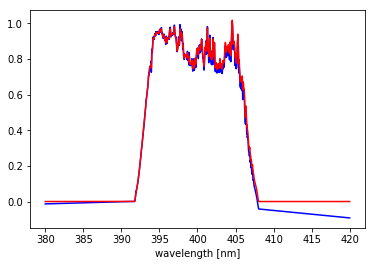

In [187]:
#read files
flatHDu1 = astropy.io.fits.open(filepath+flatfile)
dataHDu1 = astropy.io.fits.open(filepath+datafile)

flat = flatHDu1[0].data
lam = dataHDu1[7].data
print(np.shape(flat))
print(np.shape(lam))
#TRANSPOSE THE STRAIGHT DATA BC IDL CODE HAS REVERSED DIMENSIONS
#TODO FIX THIS AND ALL ARRAY SHAPES TO FOLLOW PYTHON LOADING
lam=np.transpose(lam)

#brown
#make wavelength grid
nLam = ((lamRan[1]-lamRan[0])/dLam)+1
lamGrid = lamRan[0]+dLam*np.arange(nLam,dtype=np.float64)

#brown
#make wavelength derivative, scale function to assure integral flux*dlambda
#is preserved in transformation to constant wavelength bins.

#verify data types https://www.harrisgeospatial.com/docs/PythonDataConvert.html
dLambx = np.zeros((nx,nGord),dtype=np.float64)
scale = np.zeros((nx,nGord),dtype=np.float64)



#BUG potentially the IDL code is finding the flat for the first 4 orders 
#when we want to use the last 4
for y in range(len(gOrd)) :
    #TODO first and last in each order are not accurate w idl code and precision is less
    #dlamb only accurate to 3 sigfig
    #scale is accurate against idl to about 3 decimal places
    dLambx[:,y] = np.gradient(lam[:,y]) 
    scale[:,y] =  dLambx[:,y]/dLambx[int(nx/2),y]

#print(dLambx[:,0])
#print(scale[:,0]) 


#brown 
#isolate the desired orders, set contents to zero outside boundaries.

#UNTESTED BEGIN


#TODOmnad;lsad;lsadksadjkl transpose hack blargggggggg
gFlat = np.transpose(flat[0,gOrd,:])
sgFlat = np.zeros((nx,nGord),dtype=np.float64)
#print(np.shape(gFlat))
#print(np.shape(sgFlat))


for i in range(len(gOrd)) :
    #bug cant do bounds[i,0] for some reason
    gFlat[i,0:bounds[i][0]]=0
    gFlat[i,bounds[i][1]:bounds[-1][1]]=0
    #BOX CAR SMOOTHING INSTEAD OF IDL SMOOTH(SMOOTH(SMOOTH()))
    #https://joseph-long.com/writing/AstroPy-boxcar/
    sgFlat[:,i]=convolve(gFlat[:,i]*scale[:,i], Box1DKernel(25))
    
flatOlap = np.zeros(int(nLam),dtype=np.float64)    
print('max')
m = max(sgFlat[:,1])
print(m)
    

#brown
#interpolate onto flatolap


#https://stackoverflow.com/questions/18326714/idl-interpol-equivalent-for-python
from scipy import interpolate

print(np.shape(lam))
print(np.shape(sgFlat))
print(np.shape(lam[:,66]))
print(np.shape(sgFlat[:,0]))
print(np.shape(lamGrid))
for i in range(len(gOrd)) :
    interpfunc = interpolate.interp1d(lam[:,gOrd[i]],sgFlat[:,i], kind='linear', fill_value='extrapolate')
    flatOlap = flatOlap+interpfunc(lamGrid)


#if any(i > 0 for i in flatOlap) :
 #   print('gotya')
    
#brown
#make output data array -- [lambda,flatolap].  Write it out.
output = np.zeros((int(nLam),2),dtype=np.float64)
print(np.shape(output))
output[:,0] = lamGrid    
output[:,1] = flatOlap  
    
plt.figure()
print(flatOlap)
plt.plot(lamGrid, flatOlap, 'k-',color='blue')
plt.xlabel('wavelength [nm]')


##HACK FOR PLOT
#filepath = '/home/agoga/Documents/IotaH/Code/IDLPipeline/nres_shk/data/'
#file = 'test.fits'
#hdu1 = astropy.io.fits.open(filepath+file)
#data = hdu1[0].data
#plt.plot(data[0], data[1], 'k-', color='red')